In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#import data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')

In [4]:
df.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


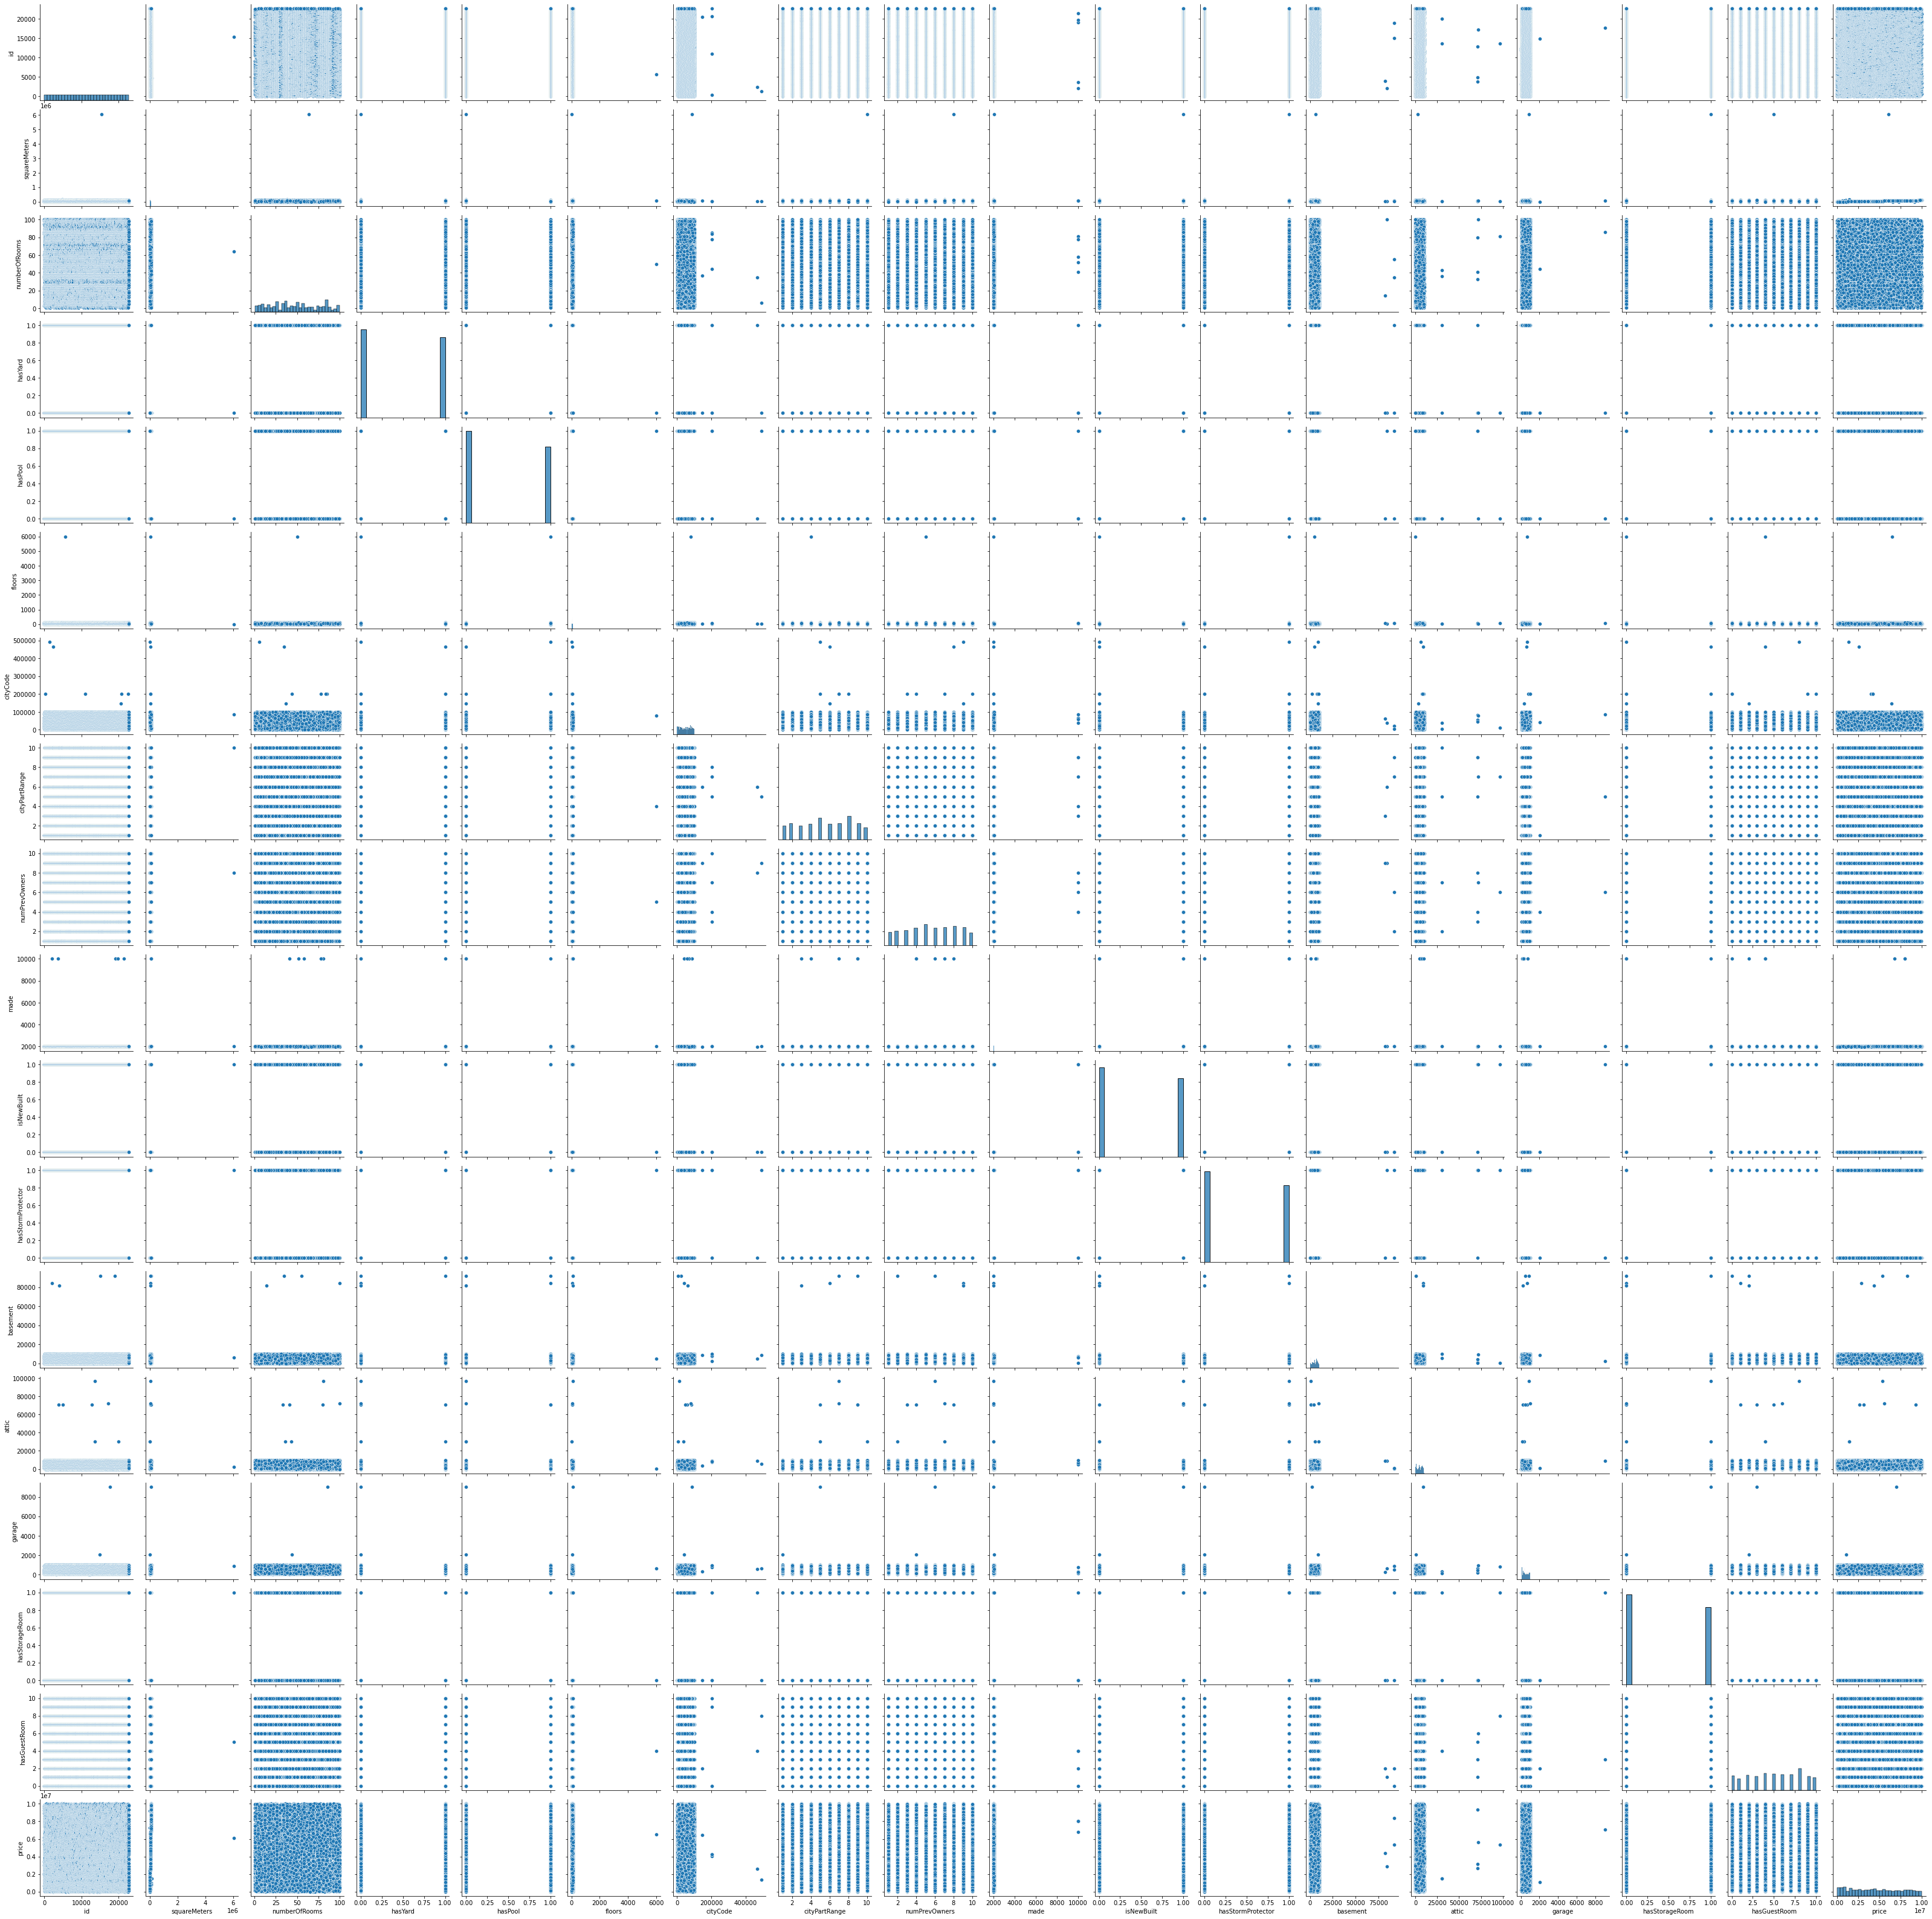

In [5]:
#Scatter plot of the data against price
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

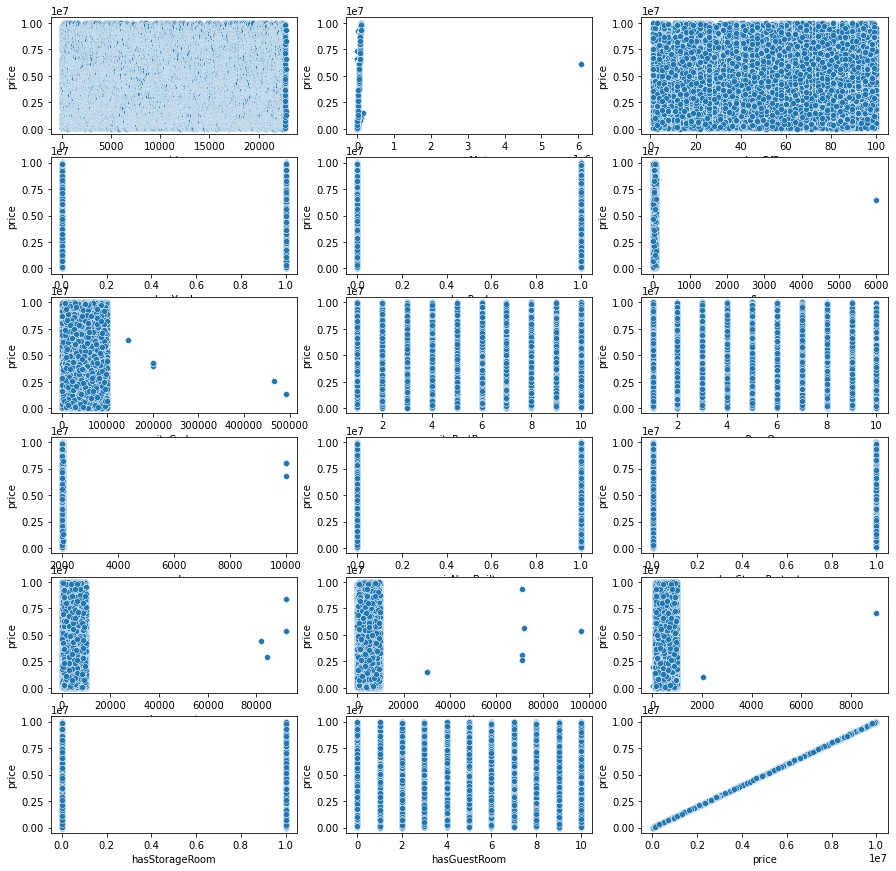

In [6]:
#Plot price against each feature
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
for i, col in enumerate(df.columns):
    sns.scatterplot(x=df[col], y=df['price'], ax=ax[i//3, i%3])

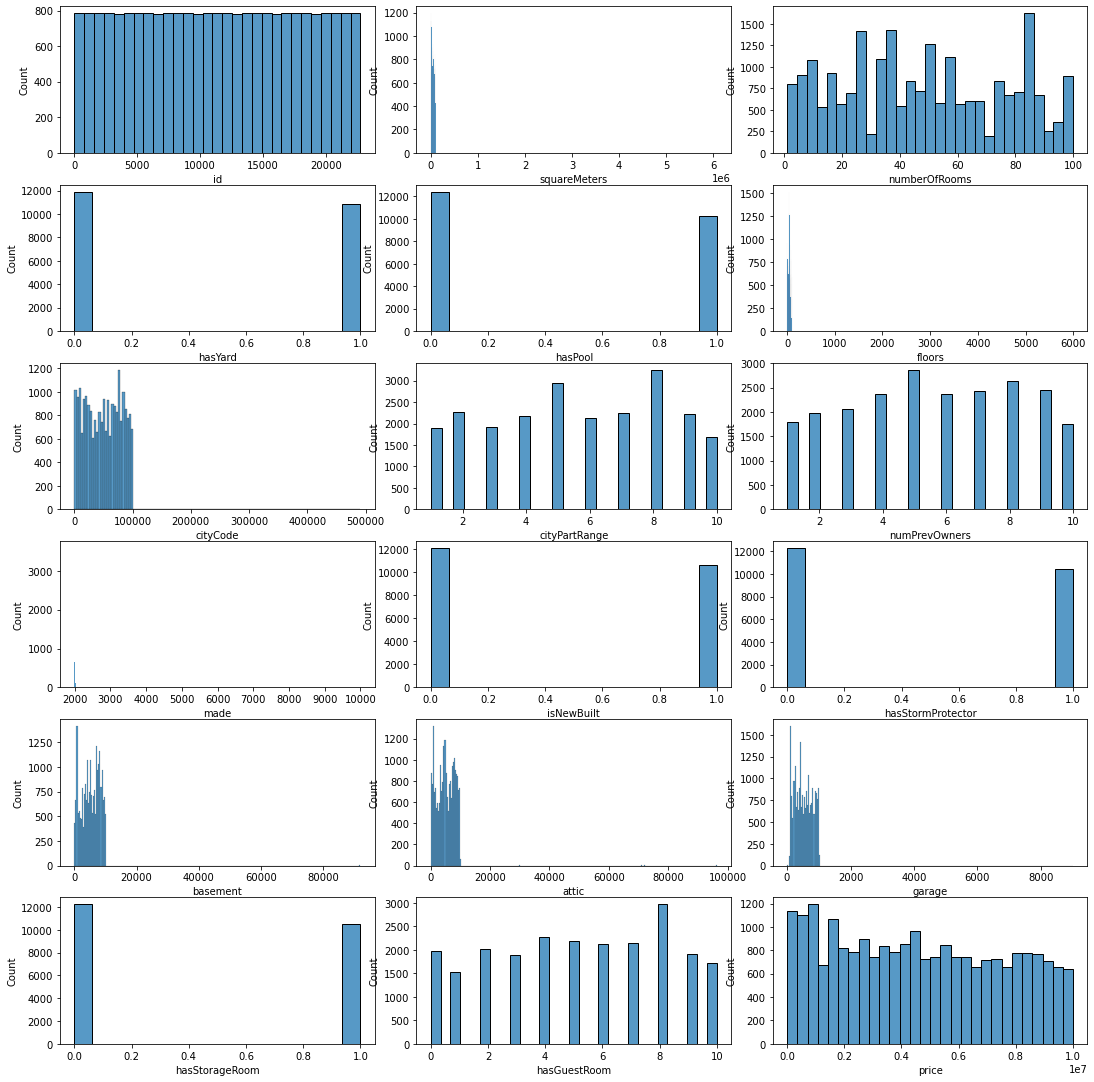

In [7]:
#histogram of each feature
fig, ax = plt.subplots(6, 3, figsize=(15, 15))
plt.tight_layout()
for i, col in enumerate(df.columns):
    sns.histplot(x=df[col], ax=ax[i//3, i%3])


<AxesSubplot:>

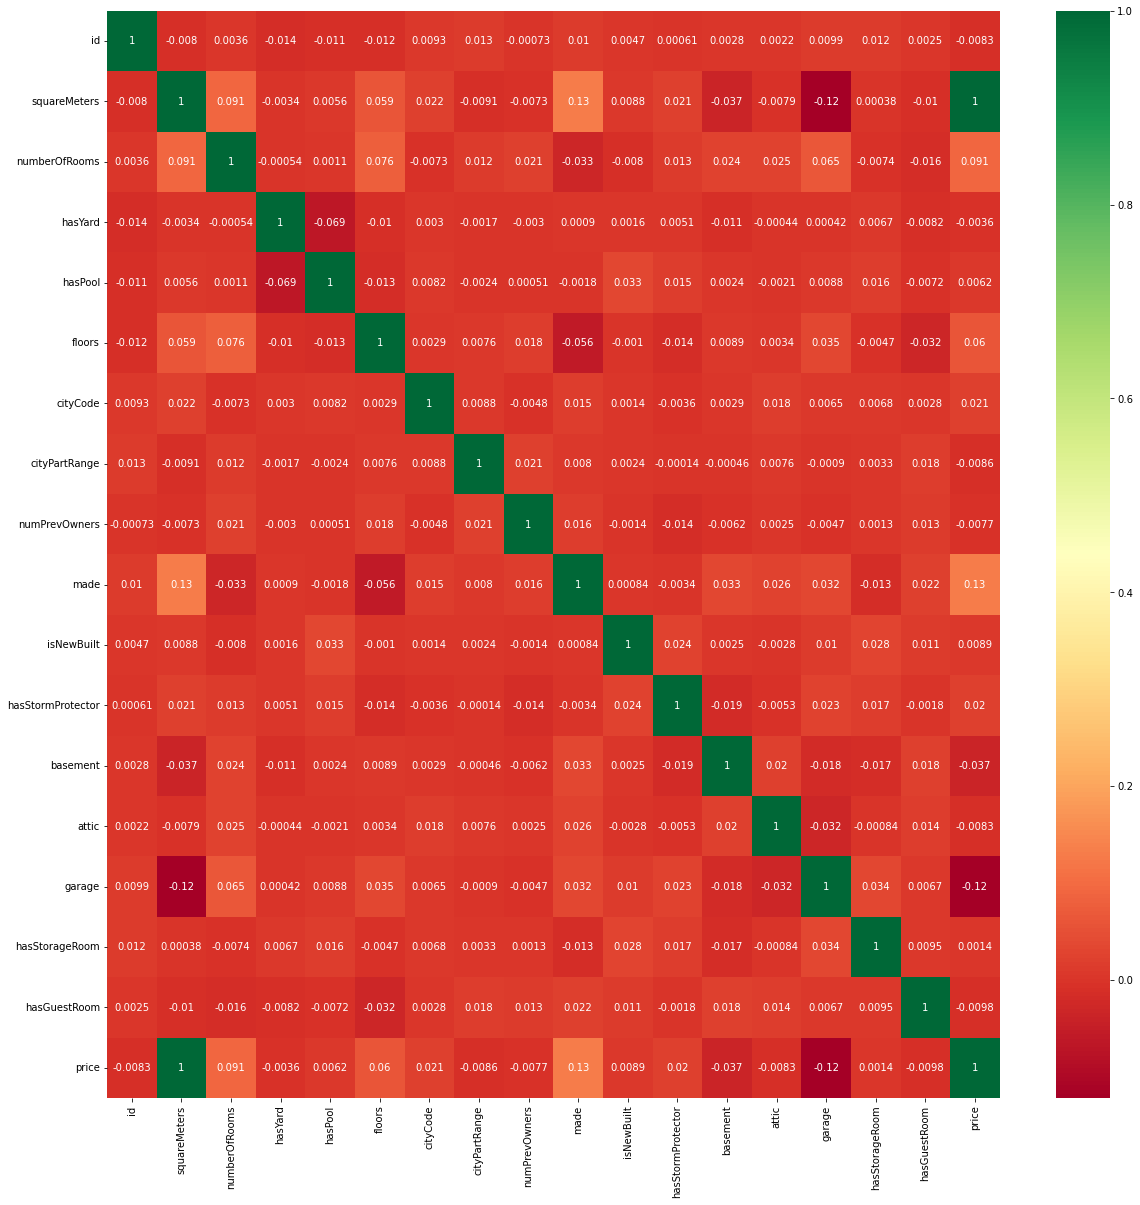

In [8]:
#Heatmap of the data with large size
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='RdYlGn')

In [9]:
#Train test split
from sklearn.model_selection import train_test_split
X = df.drop('price', axis=1)
X.drop('id',axis=1,inplace=True)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train.dtypes

squareMeters         int64
numberOfRooms        int64
hasYard              int64
hasPool              int64
floors               int64
cityCode             int64
cityPartRange        int64
numPrevOwners        int64
made                 int64
isNewBuilt           int64
hasStormProtector    int64
basement             int64
attic                int64
garage               int64
hasStorageRoom       int64
hasGuestRoom         int64
dtype: object

In [11]:
#Number of unique values in each column
X_train.nunique()

squareMeters         6423
numberOfRooms         100
hasYard                 2
hasPool                 2
floors                101
cityCode             6752
cityPartRange          10
numPrevOwners          10
made                   32
isNewBuilt              2
hasStormProtector       2
basement             4330
attic                4610
garage                891
hasStorageRoom          2
hasGuestRoom           11
dtype: int64

In [12]:
cat_cols = ['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom',]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 15911, number of used features: 16
[LightGBM] [Info] Start training from score 4612419.900729
[1]	valid_0's rmse: 2.65478e+06
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 2.39084e+06
[3]	valid_0's rmse: 2.15359e+06
[4]	valid_0's rmse: 1.94003e+06
[5]	valid_0's rmse: 1.7479e+06
[6]	valid_0's rmse: 1.575e+06
[7]	valid_0's rmse: 1.41996e+06
[8]	valid_0's rmse: 1.28044e+06
[9]	valid_0's rmse: 1.15509e+06
[10]	valid_0's rmse: 1.04276e+06
[11]	valid_0's rmse: 942150
[12]	valid_0's rmse: 851858
[13]	valid_0's rmse: 770930
[14]	valid_0's rmse: 698537
[15]	valid_0's rmse: 633870
[16]	valid_0's rmse: 576118
[17]	valid_0's rmse: 524890
[18]	valid

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

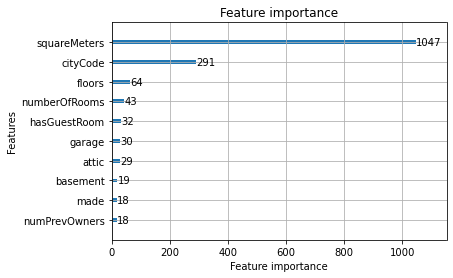

In [13]:
#Train lgbm model with rsme as metric
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
}

gbm = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=lgb_eval, early_stopping_rounds=10)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', sqrt(mean_squared_error(y_test, y_pred)))

#Plot feature importance
lgb.plot_importance(gbm, max_num_features=10)

In [14]:
# #Import test data
# test = pd.read_csv('C:/Users/tyler/Desktop/Kaggle/playground-series-season-3-episode-6/test.csv')

# #Make predictions on test data
# y_pred = gbm.predict(test, num_iteration=gbm.best_iteration)

# #Create submission file
# submission = pd.DataFrame({'id': test['id'], 'price': y_pred})
# submission.to_csv('submission.csv', index=False)


In [15]:
# #Random search for hyperparameter tuning
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform

# fit_params = {"early_stopping_rounds" : 100, 
#              "eval_metric" : 'neg_root_mean_squared_error', 
#              "eval_set" : [(X_train, y_train), (X_test, y_test)],
#              'eval_names': ['train','valid'],
#              'verbose': 0,
#              'categorical_feature': 'auto'}


# param_test = {
#               'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
#               'num_leaves': sp_randint(7, 4095), 
#               'min_child_samples': sp_randint(100, 500), 
#               'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#               'max_depth': [1, 5, 10, 50],
#               'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
#               }

# # Number of combinations
# n_iter = 100 

# #Random search with 5 fold cross validation
# clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=4, random_state=42)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test,
#     n_iter=n_iter,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     refit=True,
#     random_state=42,
#     verbose=True)

# gs.fit(X_train, y_train, **fit_params)

# #Best parameters
# t1_best_param = gs.best_params_

# #Best score
# t1_best_score = gs.best_score_
# print(t1_best_score)
# print(t1_best_param)

In [16]:
# lgb_pred = gs.predict(X_test)
# print('The rmse of prediction is:', sqrt(mean_squared_error(y_test, lgb_pred)))

In [17]:
# #Grid search for hyperparameter tuning
# from sklearn.model_selection import GridSearchCV

# param_test = {
#                 'n_estimators' : [100, 500, 1500, 2000],
#                 'max_depth': [1, 5, 50],
#                 'min_samples_split': [2, 50, 100],
#                 'min_samples_leaf': [2, 50, 100],
#                 }

# #Grid search with 5 fold cross validation
# clf = RandomForestRegressor(n_jobs=4, random_state=42)
# gs = GridSearchCV(
#     estimator=clf, param_grid=param_test,
#     n_jobs=4,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     refit=True,
#     verbose=True)

# gs.fit(X_train, y_train)

# #Best parameters
# t1_forest_best_param = gs.best_params_
# t1_forest_best_score = gs.best_score_

# print(t1_forest_best_score)
# print(t1_forest_best_param)

#results below

# Fitting 5 folds for each of 108 candidates, totalling 540 fits
# [Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
# [Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.1s
# [Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
# [Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 18.7min
# [Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 25.4min finished
# -159329.08696290728
# {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000}



Hit the upper limits for max depth and n_estimators for best result. Retrain Grid.

In [18]:
# param_test = {
#                 'n_estimators' : [2000, 5000],
#                 'max_depth': [50, 100, 200],
#                 'min_samples_split': [2],
#                 'min_samples_leaf': [2],
#                 }

# #Grid search with 5 fold cross validation
# clf2 = RandomForestRegressor(n_jobs=4, random_state=42)
# gs2 = GridSearchCV(
#     estimator=clf, param_grid=param_test,
#     n_jobs=4,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     refit=True,
#     verbose=True)

# gs2.fit(X_train, y_train)

# #Best parameters
# t2_forest_best_param = gs.best_params_
# t2_forest_best_score = gs.best_score_

# print(t2_forest_best_score)
# print(t2_forest_best_param)

No improvement

In [19]:
from sklearn.ensemble import RandomForestRegressor
best_params = {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000}
clf = RandomForestRegressor(**best_params, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('The rmse of prediction is:', sqrt(mean_squared_error(y_test, y_pred)))

The rmse of prediction is: 203188.7533887287


# Experiment with blend and stacked models with pycaret

In [20]:
!pip install -U --pre pycaret;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.1/480.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
from pycaret.regression import *

In [22]:
import pandas as pd
df = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')

In [23]:
df.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [24]:
df.drop('id',axis=1,inplace=True)

In [25]:
reg = setup(data = df, target = 'price')

,Description,Value
0,Session id,4555
1,Target,price
2,Target type,Regression
3,Original data shape,"(22730, 17)"
4,Transformed data shape,"(22730, 17)"
5,Transformed train set shape,"(15910, 17)"
6,Transformed test set shape,"(6820, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


In [26]:
no_scale_prep = get_config('X_train_transformed')
no_scale_prep

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
0,36987.0,58.0,1.0,1.0,5.0,27113.0,8.0,10.0,2003.0,1.0,1.0,5579.0,9406.0,880.0,1.0,4.0
1,92326.0,58.0,0.0,1.0,38.0,87239.0,5.0,1.0,2017.0,1.0,0.0,7661.0,775.0,495.0,1.0,1.0
2,92505.0,38.0,0.0,1.0,17.0,7737.0,4.0,8.0,1997.0,1.0,1.0,626.0,579.0,271.0,1.0,1.0
3,5916.0,45.0,0.0,1.0,8.0,16122.0,2.0,2.0,1998.0,0.0,1.0,8249.0,597.0,253.0,0.0,0.0
4,82900.0,1.0,1.0,0.0,29.0,89284.0,9.0,5.0,2013.0,0.0,1.0,2648.0,7273.0,600.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15905,32593.0,56.0,0.0,0.0,51.0,76283.0,5.0,2.0,2006.0,0.0,0.0,2851.0,3805.0,924.0,1.0,3.0
15906,33749.0,76.0,0.0,0.0,44.0,48911.0,10.0,1.0,2007.0,0.0,0.0,2329.0,5189.0,275.0,0.0,4.0
15907,76480.0,33.0,0.0,1.0,8.0,1253.0,9.0,9.0,2014.0,0.0,1.0,9938.0,9669.0,254.0,0.0,6.0
15908,733.0,18.0,1.0,0.0,38.0,81246.0,3.0,9.0,1995.0,0.0,1.0,3158.0,5931.0,746.0,0.0,3.0


In [27]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,21329.4986,29308895744.0000,159986.8203,0.9965,0.1108,0.0288,1.2680
gbr,Gradient Boosting Regressor,26562.6023,30943136050.8808,162357.2978,0.9963,0.1104,0.0330,1.3860
catboost,CatBoost Regressor,31597.0138,31881808305.4484,167812.9845,0.9962,0.1132,0.0349,4.9130
rf,Random Forest Regressor,11971.9576,31831939589.4655,165211.5044,0.9962,0.0964,0.0201,3.7090
lightgbm,Light Gradient Boosting Machine,32543.7109,34278634431.3528,175099.9322,0.9959,0.1167,0.0369,0.3560
et,Extra Trees Regressor,23514.1243,40240170070.7630,192241.7330,0.9952,0.1148,0.0318,2.6570
dt,Decision Tree Regressor,9483.7004,40518248410.5695,181217.5285,0.9952,0.1207,0.0176,0.1130
knn,K Neighbors Regressor,61983.3582,50100116889.6000,218625.1469,0.9941,0.1802,0.0770,0.4910
ada,AdaBoost Regressor,908654.1766,1221028731219.0203,1103259.2394,0.8560,0.7222,1.2364,0.7460
dummy,Dummy Regressor,2517471.5500,8491461194547.2002,2913898.7500,-0.0005,1.1494,3.7920,0.0420


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

# Load test data and make predictions

In [28]:
test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')
ids = list(test['id'])
test.drop('id',axis=1,inplace=True)

In [29]:
pred = best.predict(test)
submission_df = pd.DataFrame({'id':ids,'price':pred})
submission_df.head()

,id,price
0,22730,4765352.500
1,22731,6208267.000
2,22732,9017708.000
3,22733,1616757.875
4,22734,6767045.000


In [30]:
top3 = compare_models(n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,21329.4986,29308895744.0000,159986.8203,0.9965,0.1108,0.0288,0.0570
gbr,Gradient Boosting Regressor,26562.6023,30943136050.8808,162357.2978,0.9963,0.1104,0.0330,0.1820
catboost,CatBoost Regressor,31597.0138,31881808305.4484,167812.9845,0.9962,0.1132,0.0349,0.0410
rf,Random Forest Regressor,11971.9576,31831939589.4655,165211.5044,0.9962,0.0964,0.0201,0.4770
lightgbm,Light Gradient Boosting Machine,32543.7109,34278634431.3528,175099.9322,0.9959,0.1167,0.0369,0.0620
et,Extra Trees Regressor,23514.1243,40240170070.7630,192241.7330,0.9952,0.1148,0.0318,0.7420
dt,Decision Tree Regressor,9483.7004,40518248410.5695,181217.5285,0.9952,0.1207,0.0176,0.0410
knn,K Neighbors Regressor,61983.3582,50100116889.6000,218625.1469,0.9941,0.1802,0.0770,0.4500
ada,AdaBoost Regressor,908654.1766,1221028731219.0203,1103259.2394,0.8560,0.7222,1.2364,0.0750
dummy,Dummy Regressor,2517471.5500,8491461194547.2002,2913898.7500,-0.0005,1.1494,3.7920,0.0310


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [31]:
#Overfit
# gbr = create_model('gbr')
# tuned_gbr = tune_model(gbr, n_iter=50)

In [32]:
blender = blend_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,19524.7970,9023118333.5530,94990.0960,0.9990,0.1467,0.0232
1,19087.5699,10142259486.0175,100708.7855,0.9988,0.0773,0.0171
2,20216.1109,25017002212.4093,158167.6396,0.9971,0.1304,0.0210
3,23583.0263,22713559443.2174,150710.1836,0.9973,0.1252,0.0347
4,19914.5683,19118894684.8228,138271.0913,0.9977,0.0951,0.0226
5,22672.5146,62652359159.9187,250304.5328,0.9927,0.1154,0.0272
6,21639.4176,45939936763.4702,214336.0370,0.9946,0.0953,0.0231
7,18138.5988,7226036557.2928,85006.0972,0.9991,0.1278,0.0198
8,22166.1350,60148842938.1537,245252.6105,0.9926,0.1463,0.0714


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [33]:
pred = blender.predict(test)

In [34]:
submission_df = pd.DataFrame({'id':ids,'price':pred})
submission_df.head()

,id,price
0,22730,4.750704e+06
1,22731,6.188358e+06
2,22732,9.044925e+06
3,22733,1.623834e+06
4,22734,6.759632e+06


In [35]:
submission_df.to_csv('submission.csv',index=False)

# Following performed worse

In [36]:
# stacker = stack_models(top3)

In [37]:
# stacker_pred = stacker.predict(test)
# submission_df = pd.DataFrame({'id':ids,'price':stacker_pred})
# submission_df.to_csv('stacker_submission.csv',index=False)

# Future work

##Rename trials. I was following pycaret documentation that had bet = compare_models() but that naming convention is confusing 

* Try feature engineering. Perhaps average rooms by neighborhood?
* Bin upper levels of numerical variables
* Combine Rare levels
* Remove multicollinearity

In [38]:
#Could also look at target transform 
# reg2 = setup(data = df, target = 'price', transformation=True, remove_outliers=True)

In [39]:
# best2 = compare_models()

Possible variables are: ['variable_and_property_keys', 'X_transformed', 'is_multiclass', 'html_param', 'X_train', 'fold_groups_param', 'y_transformed', 'gpu_n_jobs_param', 'X_train_transformed', '_available_plots', 'gpu_param', 'X_test', 'exp_id', 'train_transformed', 'transform_target_param', 'idx', 'variables', 'data', 'test_transformed', 'X', '_ml_usecase', 'y_train', 'X_test_transformed', 'n_jobs_param', 'pipeline', 'dataset_transformed', 'test', 'y_test_transformed', 'dataset', 'y_train_transformed', 'y', 'log_plots_param', 'target_param', 'seed', 'logging_param', 'fold_shuffle_param', 'USI', 'train', 'memory', 'exp_name_log', 'fold_generator', 'y_test']

In [40]:
# prep_pipe = get_config('X_train_transformed')
# prep_pipe

In [41]:
# pipe = get_config('pipeline')

In [42]:
#Could try some data enginering on features by area code, but will generalize poorly if lots of new area codes
# reg3 = setup(data = df, target = 'price', group_features=['cityCode'])

In [43]:
#Bin by constructed age
# reg4 = setup(data = df, target = 'price', bin_numeric_features=['made'])

In [44]:
#Worse than best 2
# reg5 = setup(data = df, target = 'price', transformation=True, bin_numeric_features=['made'])
# best3 = compare_models()

In [45]:
#So far best2 was highest performing in RMSE
#best2

In [46]:
#Try tuning--Overfits
# tuned_best_model = tune_model(best2, optimize = 'RMSE', n_iter = 10)

In [47]:
# xgb = create_model('xgboost', Transformation=True)

In [48]:
# save_model(xgb, 'xgb_pipeline')
# xgb_pipeline = load_model('xgb_pipeline')

# Predict

In [49]:
# pred2 = predict_model(xgb_pipeline, data=test)

In [50]:
# pred2 = pred2['prediction_label']

In [51]:
# submission_df = pd.DataFrame({'id':ids,'price':pred2})
# submission_df.to_csv('submission.csv', index=False)

In [52]:
# submission_df

In [53]:
# submission_df

# Thanks for Reading!